# Research Code

## Imports
Nothing important, maybe will need to look at citations for these code libraries
- pandas: https://pandas.pydata.org/
- 

In [3]:
from config import *
from helpers_data import *
from helpers_model import *

## Load Data

In [4]:
# ONLY RUN THIS ONCE; expensive, and the data is already saved (load)

mode = "generate" # "load" or `"generate" `
if mode == "load":
    data_stimulated = load_model_data()
else:
    # see steps below in markdown
    data = load_data() # brfss data load
    data = drop_unwanted(data) # drop unwanted columns
    pop_data = load_data(data_set="census") # load census data
    stratified_data = get_stratified_data(data) # get stratified data
    data_stimulated = generate_stimulated_base(data, pop_data) # generate stimulated data BASE
    data_stimulated = stimulate_data(data_stimulated, stratified_data, mode="both") # stimulate data
    data_stimulated = encode_data(data_stimulated) # encode data (categorical values)
    save_data(data_stimulated) # save dataset

## Trim
1. Get rid of all unused topics.
2. Get rid of empty entries
    - for future research, possibly add these categories in with new data
3. Get rid of dropped entries (see section on `Methodology` below)

In [ ]:
{
 "cells": [
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "# Import Required Libraries\n",
    "Import the necessary libraries, including normflows, pandas, and scikit-learn."
   ]
  },
  {
   "cell_type": "code",
   "execution_count": null,
   "metadata": {},
   "outputs": [],
   "source": [
    "# Import Required Libraries\n",
    "# ML\n",
    "import torch\n",
    "import torch.nn as nn\n",
    "import normflows as nf\n",
    "import pytorch_lightning as pl\n",
    "\n",
    "# Data\n",
    "import pandas as pd\n",
    "\n",
    "# Metrics\n",
    "from sklearn.model_selection import train_test_split\n",
    "from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score"
   ]
  },
  {
   "cell_type": "code",
   "execution_count": null,
   "metadata": {},
   "outputs": [],
   "source": [
    "# Custom\n",
    "from helpers_data import *\n",
    "from helpers_model import randomized_train_test"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "# Load Dataset\n",
    "Load the precomputed dataset using pandas."
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 3,
   "metadata": {},
   "outputs": [],
   "source": [
    "mode = \"load\" # \"load\" or `\"generate\" `\n",
    "if mode == \"load\":\n",
    "    data_stimulated = load_model_data()\n",
    "else:\n",
    "    # see steps below in markdown\n",
    "    data = load_data() # brfss data load\n",
    "    data = drop_unwanted(data) # drop unwanted columns\n",
    "    pop_data = load_data(data_set=\"census\") # load census data\n",
    "    stratified_data = get_stratified_data(data) # get stratified data\n",
    "    data_stimulated = generate_stimulated_base(data, pop_data) # generate stimulated data BASE\n",
    "    data_stimulated = stimulate_data(data_stimulated, stratified_data, mode=\"both\") # stimulate data\n",
    "    data_stimulated = encode_data(data_stimulated) # encode data (categorical values)\n",
    "    save_data(data_stimulated) # save dataset"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "# Preprocess Data\n",
    "Preprocess the data, including splitting into features and labels, and standardizing the features."
   ]
  },
  {
   "cell_type": "code",
   "execution_count": 4,
   "metadata": {},
   "outputs": [],
   "source": [
    "X_train, X_test, y_train, y_test = randomized_train_test(data_stimulated)"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "# Define Normalizing Flow Model\n",
    "Define the architecture of the normalizing flow model using normflows."
   ]
  },
  {
   "cell_type": "code",
   "execution_count": null,
   "metadata": {},
   "outputs": [],
   "source": [
    "class NormalizingFlowModel(pl.LightningModule):\n",
    "    def __init__(self, input_dim, n_flows=4, lr=1e-3):\n",
    "        super(NormalizingFlowModel, self).__init__()\n",
    "        self.save_hyperparameters()\n",
    "        \n",
    "        # Define the base distribution (standard normal)\n",
    "        self.base = nf.distributions.base.DiagGaussian(input_dim)\n",
    "        \n",
    "        # Define the flow layers\n",
    "        self.flows = [nf.flows.Radial(input_dim) if i % 2 == 0 else nf.flows.Planar(input_dim) for i in range(n_flows * 2)]\n",
    "        \n",
    "        # Combine the base distribution and flow layers into a normalizing flow model\n",
    "        self.model = nf.NormalizingFlow(self.base, self.flows)\n",
    "        \n",
    "    def forward(self, x):\n",
    "        return self.model.log_prob(x)\n",
    "    \n",
    "    def training_step(self, batch, batch_idx):\n",
    "        x, _ = batch\n",
    "        loss = -self.model.log_prob(x).mean()\n",
    "        self.log('train_loss', loss)\n",
    "        return loss\n",
    "    \n",
    "    def configure_optimizers(self):\n",
    "        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "# Train Normalizing Flow Model\n",
    "Train the normalizing flow model on the preprocessed dataset."
   ]
  },
  {
   "cell_type": "code",
   "execution_count": null,
   "metadata": {},
   "outputs": [],
   "source": [
    "# Convert training data to torch tensors\n",
    "X_train_tensor = torch.tensor(X_train, dtype=torch.float32)\n",
    "y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)\n",
    "\n",
    "# Create DataLoader\n",
    "train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)\n",
    "train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)\n",
    "\n",
    "# Initialize model\n",
    "input_dim = X_train.shape[1]\n",
    "model = NormalizingFlowModel(input_dim)\n",
    "\n",
    "# Initialize Trainer\n",
    "trainer = pl.Trainer(max_epochs=100)\n",
    "\n",
    "# Train the model\n",
    "trainer.fit(model, train_loader)"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "# Generate Samples from Trained Model\n",
    "Generate samples from the trained normalizing flow model to capture the underlying distribution."
   ]
  },
  {
   "cell_type": "code",
   "execution_count": null,
   "metadata": {},
   "outputs": [],
   "source": [
    "# Generate Samples from Trained Model\n",
    "\n",
    "import matplotlib.pyplot as plt\n",
    "\n",
    "# Set the model to evaluation mode\n",
    "model.eval()\n",
    "\n",
    "# Generate samples from the trained model\n",
    "num_samples = 1000\n",
    "samples = model.model.sample(num_samples).detach().numpy()\n",
    "\n",
    "# Plot the generated samples to visualize the underlying distribution\n",
    "plt.figure(figsize=(8, 6))\n",
    "plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5)\n",
    "plt.title('Generated Samples from Trained Normalizing Flow Model')\n",
    "plt.xlabel('Feature 1')\n",
    "plt.ylabel('Feature 2')\n",
    "plt.show()"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "# Class Prediction Using Generated Samples\n",
    "Use the generated samples to perform class prediction."
   ]
  },
  {
   "cell_type": "code",
   "execution_count": null,
   "metadata": {},
   "outputs": [],
   "source": [
    "# Class Prediction Using Generated Samples\n",
    "\n",
    "# Convert generated samples to torch tensor\n",
    "samples_tensor = torch.tensor(samples, dtype=torch.float32)\n",
    "\n",
    "# Get log probabilities for generated samples\n",
    "log_probs_samples = model(samples_tensor)\n",
    "\n",
    "# Convert log probabilities to class predictions (assuming binary classification)\n",
    "y_pred_samples = (log_probs_samples > log_probs_samples.mean()).float().numpy()\n",
    "\n",
    "# Calculate evaluation metrics using generated samples\n",
    "accuracy_samples = accuracy_score(y_test, y_pred_samples[:len(y_test)])\n",
    "f1_samples = f1_score(y_test, y_pred_samples[:len(y_test)])\n",
    "precision_samples = precision_score(y_test, y_pred_samples[:len(y_test)])\n",
    "recall_samples = recall_score(y_test, y_pred_samples[:len(y_test)])\n",
    "\n",
    "print(f'Generated Samples - Accuracy: {accuracy_samples:.4f}')\n",
    "print(f'Generated Samples - F1 Score: {f1_samples:.4f}')\n",
    "print(f'Generated Samples - Precision: {precision_samples:.4f}')\n",
    "print(f'Generated Samples - Recall: {recall_samples:.4f}')"
   ]
  },
  {
   "cell_type": "markdown",
   "metadata": {},
   "source": [
    "# Evaluate Model Performance\n",
    "Evaluate the performance of the model using metrics such as accuracy, precision, recall, and F1 score."
   ]
  },
  {
   "cell_type": "code",
   "execution_count": null,
   "metadata": {},
   "outputs": [],
   "source": [
    "# Evaluate Model Performance\n",
    "\n",
    "# Evaluate the model\n",
    "model.eval()\n",
    "with torch.no_grad():\n",
    "    # Convert test data to torch tensor\n",
    "    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)\n",
    "    \n",
    "    # Get log probabilities for test data\n",
    "    log_probs = model(X_test_tensor)\n",
    "    \n",
    "    # Convert log probabilities to class predictions (assuming binary classification)\n",
    "    y_pred = (log_probs > log_probs.mean()).float().numpy()\n",
    "    \n",
    "    # Calculate evaluation metrics\n",
    "    accuracy = accuracy_score(y_test, y_pred)\n",
    "    f1 = f1_score(y_test, y_pred)\n",
    "    precision = precision_score(y_test, y_pred)\n",
    "    recall = recall_score(y_test, y_pred)\n",
    "    \n",
    "    print(f'Accuracy: {accuracy:.4f}')\n",
    "    print(f'F1 Score: {f1:.4f}')\n",
    "    print(f'Precision: {precision:.4f}')\n",
    "    print(f'Recall: {recall:.4f}')"
   ]
  }
 ],
 "metadata": {
  "kernelspec": {
   "display_name": "venv",
   "language": "python",
   "name": "python3"
  },
  "language_info": {
   "codemirror_mode": {
    "name": "ipython",
    "version": 3
   },
   "file_extension": ".py",
   "mimetype": "text/x-python",
   "name": "python",
   "nbconvert_exporter": "python",
   "pygments_lexer": "ipython3",
   "version": "3.12.6"
  }
 },
 "nbformat": 4,
 "nbformat_minor": 2
}

## Methodology

1. Get U.S. population counts for `age groups`, `ethnicities/gender`, and `regions` from `2015-2022`
    - Ages
        - `65 years or older`
        - `50-64 years`
        - `Overall` ——— Below 50
    - Gender/Ethnicities
        - `FEMALE`
        - `MALE`
        - `Overall` ——— other/all [gender only]
        - `WHT` ——— White
        - `BLK` ——— Black
        - `HIS` ——— Hispanic
        - `NAA` ——— Native American
        - `ASN` ——— Asian
    - Regions
        - `United States, DC & Territories` [DROP]
        - `West` [DROP]
        - `South` [DROP]
        - `Midwest` [DROP]
        - `Northeast` [DROP]
        - 50 states & D.C. [individually] 
        - `Puerto Rico` [DROP]
        - `Guam` [DROP]
        - `Virgin Islands` [DROP]
3. Stimulate the U.S. using these populations and responses to the question
    - Assign everyone `known Alzheimer's patient` or `apparently no Alzheimer's`
4. Stimulate features using probabilities for patients and non-patients


## Stimulate Data
### Load Census Data
Population data obtained from the U.S. Census

### Go by year
NOTE: Data has a 90% confidence interval, and will be sample as such

- Onehot encode AGE_GROUP, NAME, SEX, and RACE
- first cast to letters

## Model

In [5]:
X_train, X_test, y_train, y_test = randomized_train_test(data_stimulated)

In [6]:
fn = X_train.columns
cn=('No', 'Yes')

In [7]:
mode = "train" # "load" or "train" or "hypertune"
if mode == "train":
    tuned_model = train_model(X_train, y_train, scoring="accuracy", model_args={'n_estimators': 100, 'criterion': 'log_loss', 'oob_score':True})
elif mode == "train":
    tuned_model = load_model()
else:
    param_grid = {
        'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800],
        'max_features': [None, 'sqrt', 'log2'],
        'max_depth' : [None, 4,5,6,7,8],
        'criterion' :['gini', 'entropy', 'log_loss'],
        "max_leaf_nodes": [None, 2, 5, 10, 20, 50, 100, 200, 300],
        "monotonic_cst": [None, [1, 1], [-1, -1], [1, 0], [0, 1], [-1, 0], [0, -1]]
    }
    tuned_params = find_best_hyperparameters(X_train, y_train, param_grid, scoring="accuracy", n_iter=100, cv=None)
    print(tuned_params)
    tuned_model = train_model(X_train, y_train, scoring="accuracy", tuned_params=tuned_params)

In [8]:
save = False
if save:
    save_model(tuned_model)

Plot Tree as png (too big, don't do it often)

In [9]:
create_tree = False
if create_tree:    
    sklearn.tree.export_graphviz(
        tuned_model.estimator_.estimators_[0],
        open("figures/random_forest.dot", "w"),
        feature_names=fn,
        class_names=cn,
        filled=True
        )

    graph = graphviz.Source.from_file("figures/random_forest.dot")
    graph.format = 'svg'
    graph.render("figures/random_forest.svg", format='svg', cleanup=True)

In [10]:
accuracy_score(y_test, tuned_model.predict(X_test))

0.6236054744461428

In [11]:
f1_score(y_test, tuned_model.predict(X_test))

np.float64(0.616913228509781)

In [12]:
precision_score(y_test, tuned_model.predict(X_test))

np.float64(0.6536899611583036)

In [13]:
recall_score(y_test, tuned_model.predict(X_test))

np.float64(0.5840542172413987)

In [14]:
print(classification_report(y_test, tuned_model.predict(X_test), labels=[0, 1], target_names=["non-AD", "AD"]))

              precision    recall  f1-score   support

      non-AD       0.60      0.67      0.63    164301
          AD       0.65      0.58      0.62    177213

    accuracy                           0.62    341514
   macro avg       0.63      0.63      0.62    341514
weighted avg       0.63      0.62      0.62    341514



In [29]:
importance = [tree.feature_importances_ for tree in tuned_model.estimator_.estimators_]
std = np.std(importance, axis=0) * 100
mean = np.mean(importance, axis=0) * 100
median = np.median(importance, axis=0) * 100
list(zip(fn, mean, std))

[('Frequent mental distress',
  np.float64(2.9580363273256465),
  np.float64(1.0136540007502894)),
 ('Prevalence of sufficient sleep',
  np.float64(3.803451185946386),
  np.float64(1.4154103457564096)),
 ('Eating 2 or more fruits daily',
  np.float64(18.989854259281113),
  np.float64(1.0481810964767155)),
 ('Eating 3 or more vegetables daily',
  np.float64(2.872388827932592),
  np.float64(1.0331452972421635)),
 ('Lifetime diagnosis of depression',
  np.float64(4.589582712731776),
  np.float64(1.2666190138939923)),
 ('Obesity', np.float64(3.8676993536044946), np.float64(1.2457327806111476)),
 ('Fall with injury within last year',
  np.float64(8.069138306697363),
  np.float64(0.8672453732447077)),
 ('Age_Group_50-64 years',
  np.float64(1.5003625648680592),
  np.float64(1.047261187179542)),
 ('Age_Group_65 years or older',
  np.float64(5.505713646557622),
  np.float64(2.0185193460449637)),
 ('Age_Group_Overall',
  np.float64(2.293743668196866),
  np.float64(1.3431669118646434)),
 ('Locat

Plot pie chart

In [16]:
from sklearn.ensemble import GradientBoostingClassifier

gp = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=0, init=load_model(), verbose=1, warm_start=True, n_iter_no_change=10, tol=0.0001, validation_fraction=0.1)

/Users/saad/Documents/School/Research/Alzheimer_2024/venv/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/saad/Documents/School/Research/Alzheimer_2024/venv/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/saad/Documents/School/Research/Alzheimer_2024/venv/lib/python3.12/site-packages/sklearn/base.py:3

In [17]:
gp.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           0.5795            4.62m
         2           0.5795            5.07m
         3           0.5795            4.95m
         4           0.5795            4.89m
         5           0.5795            4.81m
         6           0.5795            4.72m
         7           0.5795            4.66m
         8           0.5795            4.62m
         9           0.5795            4.55m
        10           0.5795            4.51m


GradientBoostingClassifier(init=TunedThresholdClassifierCV(estimator=RandomForestClassifier(criterion='log_loss',
                                                                                            n_jobs=-1,
                                                                                            random_state=639242650),
                                                           n_jobs=-1,
                                                           scoring='f1',
                                                           store_cv_results=True),
                           n_iter_no_change=10, random_state=0, verbose=1,
                           warm_start=True)

In [60]:
from sklearn.model_selection import TunedThresholdClassifierCV
gp_tuned = TunedThresholdClassifierCV(gp, cv=5, n_jobs=-1, scoring="f1")

In [61]:
gp_tuned.fit(X_train, y_train)

TunedThresholdClassifierCV(cv=5, estimator=MLPClassifier(), n_jobs=-1,
                           scoring='f1')

In [18]:
print(classification_report(y_test, gp.predict(X_test), labels=[0, 1], target_names=["non-AD", "AD"]))
# print(classification_report(y_test, gp_tuned.predict(X_test), labels=[0, 1], target_names=["non-AD", "AD"]))
print("Precision score ", precision_score(y_test, gp.predict(X_test)), precision_score(y_test, gp_tuned.predict(X_test)))
print("Recall score ", recall_score(y_test, gp.predict(X_test)), recall_score(y_test, gp_tuned.predict(X_test)))
print("F1 score ", f1_score(y_test, gp.predict(X_test)), f1_score(y_test, gp_tuned.predict(X_test)))

              precision    recall  f1-score   support

      non-AD       0.89      0.98      0.93    300999
          AD       0.39      0.08      0.13     40515

    accuracy                           0.88    341514
   macro avg       0.64      0.53      0.53    341514
weighted avg       0.83      0.88      0.84    341514



NameError: name 'gp_tuned' is not defined

In [18]:
# weights = np.append(mean[[3, 0, 2, 6, 10, 1, 9]], mean[[4, 5, 7, 8]].sum())
# weights /= weights.sum()
# weights
# plt.title("Importance Factor of Selected Features", loc="left", pad=20)
# plt.pie(
#     weights, 
#     labels=["Race", "Age", "Sex", 'Eating 2 or more fruits daily', 'Fall with injury within last year', "State of Residence", "Other"])

In [15]:
cm = confusion_matrix(y_test, tuned_model.predict(X_test))
cm

array([[109468,  54833],
       [ 73711, 103502]])

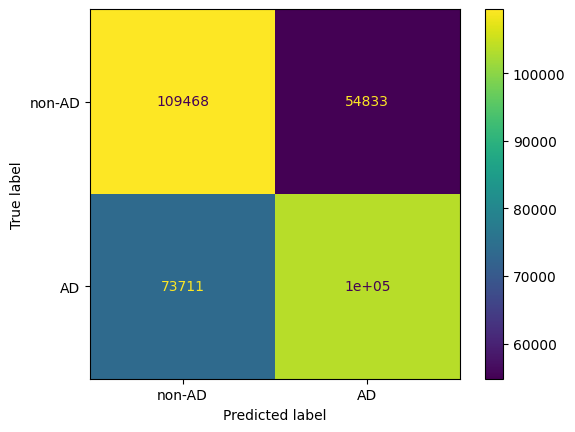

In [16]:
ConfusionMatrixDisplay(cm, display_labels=["non-AD", "AD"]).plot()

In [12]:
# Identify one-hot encoded columns
age_group_cols = [col for col in data_stimulated.columns if col.startswith('Age_Group')]
location_cols = [col for col in data_stimulated.columns if col.startswith('Location')]
sex_cols = [col for col in data_stimulated.columns if col.startswith('Sex')]
race_cols = [col for col in data_stimulated.columns if col.startswith('Race_code')]

# Identify other columns
other_cols = [col for col in data_stimulated.columns if col not in age_group_cols + location_cols + sex_cols + race_cols ] # + ["HAS_ALZHEIMERS"]

# Generate a sample of combinations for one-hot encoded columns without using product
def generate_combinations(sample_size=1000):
    for _ in range(sample_size):
        age_bits = [rng.choice([0, 1]) for _ in range(len(age_group_cols))]
        loc_bits = [rng.choice([0, 1]) for _ in range(len(location_cols))]
        sex_bits = [rng.choice([0, 1]) for _ in range(len(sex_cols))]
        race_bits = [rng.choice([0, 1]) for _ in range(len(race_cols))]
        other_bits = [rng.choice([0, 1]) for _ in range(len(other_cols))]
        yield age_bits + loc_bits + sex_bits + race_bits + other_bits

# Create a DataFrame with a sample of combinations using lazy generation
variable_checker = pd.DataFrame(generate_combinations(), columns=data_stimulated.columns)

In [13]:
if "Oral health:  tooth retention" in variable_checker.columns:
    variable_checker = variable_checker.drop(["Oral health:  tooth retention"], axis=1)
variable_checker["Predicted"] = tuned_model.predict(variable_checker.drop("HAS_ALZHEIMERS", axis=1))

In [14]:
variable_checker.columns

Index(['HAS_ALZHEIMERS', 'Frequent mental distress',
       'Prevalence of sufficient sleep', 'Eating 2 or more fruits daily',
       'Eating 3 or more vegetables daily', 'Lifetime diagnosis of depression',
       'Obesity', 'Fall with injury within last year', 'Age_Group_50-64 years',
       'Age_Group_65 years or older', 'Age_Group_Overall', 'Location_Alabama',
       'Location_Alaska', 'Location_Arizona', 'Location_Arkansas',
       'Location_California', 'Location_Colorado', 'Location_Connecticut',
       'Location_Delaware', 'Location_District of Columbia',
       'Location_Florida', 'Location_Georgia', 'Location_Hawaii',
       'Location_Idaho', 'Location_Illinois', 'Location_Indiana',
       'Location_Iowa', 'Location_Kansas', 'Location_Kentucky',
       'Location_Louisiana', 'Location_Maine', 'Location_Maryland',
       'Location_Massachusetts', 'Location_Michigan', 'Location_Minnesota',
       'Location_Mississippi', 'Location_Missouri', 'Location_Montana',
       'Location_Ne

In [15]:
state_to_abbreviation = {
    "Alabama": "AL", "Alaska": "AK", "Arizona": "AZ", "Arkansas": "AR", "California": "CA", "Colorado": "CO",
    "Connecticut": "CT", "Delaware": "DE", "District of Columbia": "DC", "Florida": "FL", "Georgia": "GA", "Hawaii": "HI",
    "Idaho": "ID", "Illinois": "IL", "Indiana": "IN", "Iowa": "IA", "Kansas": "KS", "Kentucky": "KY", "Louisiana": "LA",
    "Maine": "ME", "Maryland": "MD", "Massachusetts": "MA", "Michigan": "MI", "Minnesota": "MN", "Mississippi": "MS",
    "Missouri": "MO", "Montana": "MT", "Nebraska": "NE", "Nevada": "NV", "New Hampshire": "NH", "New Jersey": "NJ",
    "New Mexico": "NM", "New York": "NY", "North Carolina": "NC", "North Dakota": "ND", "Ohio": "OH", "Oklahoma": "OK",
    "Oregon": "OR", "Pennsylvania": "PA", "Rhode Island": "RI", "South Carolina": "SC", "South Dakota": "SD",
    "Tennessee": "TN", "Texas": "TX", "Utah": "UT", "Vermont": "VT", "Virginia": "VA", "Washington": "WA",
    "West Virginia": "WV", "Wisconsin": "WI", "Wyoming": "WY"
}


In [16]:
age_values = ["Overall", "50-64 years", "65 years or older"]
state_values = list(state_to_abbreviation.keys())
race_values = ["Hispanic", "White", "Black", "Native American", "Asian", "Native American"]

# Corrected map_category_to_vals dictionary
map_category_to_vals = {
    'AGE_GROUP': age_values,
    'NAME': state_values, 
    'SEX': {
        0: "All genders", 
        1: "Male", 
        2: "Female"
    }, 
    'RACE': race_values, 
    'Frequent mental distress': None, 
    'Prevalence of sufficient sleep': None, 
    'Eating 2 or more fruits daily': None, 
    'Eating 3 or more vegetables daily': None, 
    'Lifetime diagnosis of depression': None, 
    'Obesity': None, 
    'Fall with injury within last year': None,
}

def get_factor_string(factor: str, val: int) -> str:
    if not map_category_to_vals[factor]:
        return f'{factor}: {"Present" if val == 1 else "Absent"}'
    if factor == "NAME":
        return map_category_to_vals[factor][val]
    return f'{factor}: {map_category_to_vals[factor][val]}'

In [18]:
variable_checker = variable_checker.drop_duplicates()
plotting_data = []
state_data = []

unique_values = {
    "Age_Group": age_values,
    "Location": state_values,
    "Sex": list(pop_sex_to_stratified.values()),
    "Race_code": list(pop_race_to_stratified.values()),
    "Frequent mental distress": [0, 1],
    "Prevalence of sufficient sleep": [0, 1],
    "Eating 2 or more fruits daily": [0, 1],
    "Eating 3 or more vegetables daily": [0, 1],
    "Lifetime diagnosis of depression": [0, 1],
    "Obesity": [0, 1],
    "Fall with injury within last year": [0, 1]
}

try:
    unique_values.pop("HAS_ALZHEIMERS")    
except KeyError:
    print('"HAS_ALZHEIMERS" not in unique_values')
try:
    unique_values.pop("Oral health:  tooth retention")
except KeyError:
    print('"Oral health: tooth retention" not in unique_values')

for factor, values in unique_values.items():
    for value in values:
        if factor in ['Age_Group', 'Location', 'Sex', 'Race_code']:
            column_name = f"{factor}_{value}"
        else:
            column_name = factor
        
        variable_checker_subset = variable_checker[(variable_checker[column_name] == 1) & (variable_checker["HAS_ALZHEIMERS"] == 1)]
        current_data = (
            get_factor_string(factor, value), 
            variable_checker_subset[variable_checker_subset["Predicted"] == 1]["Predicted"].sum() / variable_checker_subset["Predicted"].count() * 100
        )
        if factor != "Location":
            plotting_data.append(current_data)
        else:
            state_data.append(current_data)
        print(f'People with the characteristic "{current_data[0]}" have {current_data[1]}% chance of having AD')


"HAS_ALZHEIMERS" not in unique_values
"Oral health: tooth retention" not in unique_values


KeyError: 'Age_Group'

In [ ]:
labels = [
    "AGE_GROUP", "SEX", "RACE", "Frequent mental distress", 
    "Prevalence of sufficient sleep", "Eating 2 or more fruits daily", 
    "Eating 3 or more vegetables daily", "Lifetime diagnosis of depression", 
    "Obesity", "Fall with injury within last year"
]

pairs = [
    ("AGE_GROUP: 50-64 years", "AGE_GROUP: 65 years or older", "AGE_GROUP: Overall"),
    ("SEX: All genders", "SEX: Male", "SEX: Female"),
    ("RACE: Hispanic", "RACE: White", "RACE: Black", "RACE: Native American", "RACE: Asian", "RACE: Native American"),
    ("Frequent mental distress: Present", "Frequent mental distress: Absent"),
    ("Prevalence of sufficient sleep: Present", "Prevalence of sufficient sleep: Absent"),
    ("Eating 2 or more fruits daily: Absent", "Eating 2 or more fruits daily: Present"),
    ("Eating 3 or more vegetables daily: Absent", "Eating 3 or more vegetables daily: Present"),
    ("Lifetime diagnosis of depression: Absent", "Lifetime diagnosis of depression: Present"),
    ("Obesity: Present", "Obesity: Absent"),
    ("Fall with injury within last year: Present", "Fall with injury within last year: Absent")
]

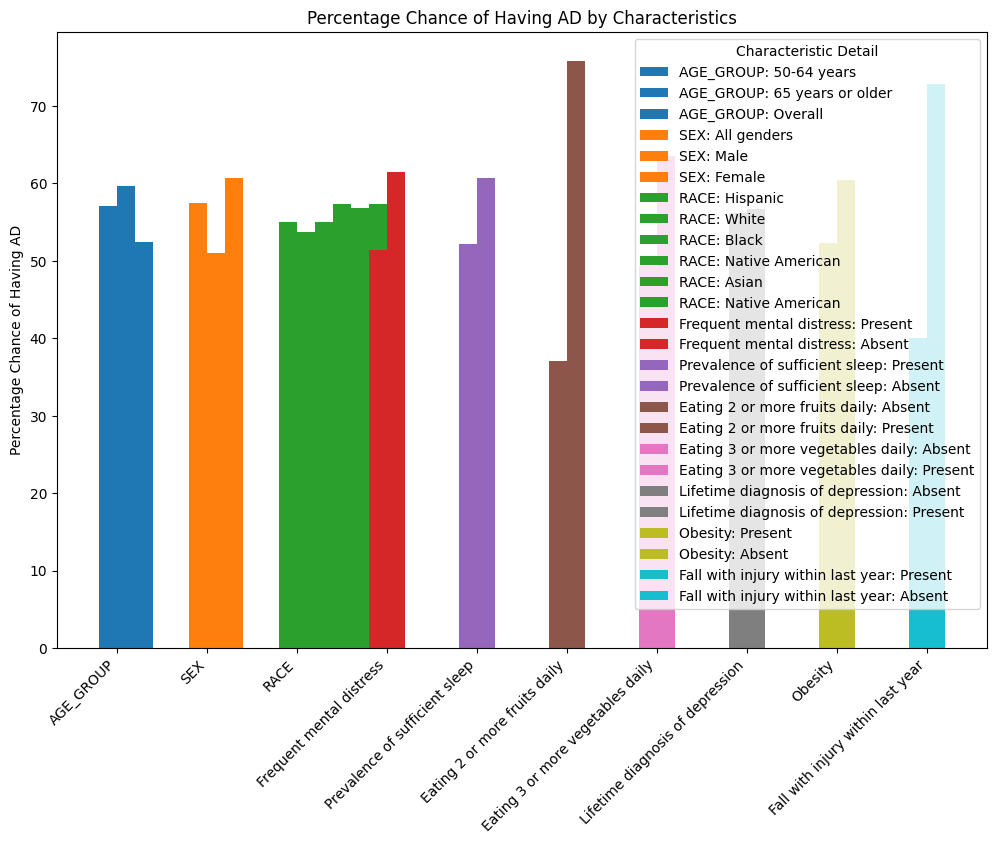

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
for idx, group in enumerate(pairs):
    values = [next((item[1] for item in plotting_data if item[0] == characteristic), 0) for characteristic in group]
    positions = [idx * 2 + i * 0.4 for i in range(len(group))]
    ax.bar(positions, values, width=0.4, label=group)

    ax.set_ylabel('Percentage Chance of Having AD')
ax.set_title('Percentage Chance of Having AD by Characteristics')
ax.set_xticks([i * 2 + 0.2 for i in range(len(pairs))])
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.legend(title="Characteristic Detail")

plt.show()

In [ ]:
state_to_abbreviation = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "District of Columbia": "DC",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY"
}

In [ ]:
states = [state_to_abbreviation[item[0]] for item in state_data]
values = [item[1] for item in state_data]

In [ ]:
state_fig = go.Figure(data=go.Choropleth(
    locations=states,  # Spatial coordinates
    z=values,  # Data to be color-coded
    locationmode='USA-states',  # set of locations match entries in `locations`
    colorscale='Blues',
    # colorbar_title="Percentage Chance of Having AD",
))

state_fig.update_layout(
    # title_text='Percentage Chance of Having Alzheimer\'s Disease by State',
    geo_scope='usa',  # limit map scope to USA
)

state_fig.show()

In [40]:
data_stimulated["Predicted1"] = tuned_model.predict(data_stimulated.drop(["HAS_ALZHEIMERS", "Oral health:  tooth retention"], axis=1))

In [28]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

tuned_models = {
    'lr_saga_l2': LogisticRegression(
        penalty="l2",
        solver="saga",
        random_state=int(rng.random() * 280741231)),
    'gb': GradientBoostingClassifier(        
        random_state=int(rng.random() * 280741231)),
    'rf': RandomForestClassifier(
        random_state=int(rng.random() * 280741231)),
    'knn': KNeighborsClassifier(
        n_neighbors=2)
}

In [29]:
for model_name, model in tuned_models.items():
    tuned_models[model_name] = TunedThresholdClassifierCV(
        model,
        n_jobs=-1
    )
    model = tuned_models[model_name]
    model.fit(X_train, y_train)
    accuracy = accuracy_score(y_test, model.predict(X_test))
    f1 = f1_score(y_test, model.predict(X_test))
    precision = precision_score(y_test, model.predict(X_test))
    recall = recall_score(y_test, model.predict(X_test))
    print(f'{model_name} accuracy: {accuracy}, f1: {f1}, precision: {precision}, recall: {recall}')

lr_saga_l2 accuracy: 0.6581702121429512, f1: 0.5213906483816083, precision: 0.4708005552984729, recall: 0.5841620541558531
gb accuracy: 0.6692531806802043, f1: 0.5283223718550997, precision: 0.4842963501693812, recall: 0.581153395650077
rf accuracy: 0.6536316120814606, f1: 0.5156515508240352, precision: 0.46514247723873015, recall: 0.5784662731678188
knn accuracy: 0.5670468354245055, f1: 0.4727852953236705, precision: 0.3863434390524614, recall: 0.6090581291196803


gb accuracy: 0.6692531806802043, f1: 0.5283223718550997, precision: 0.4842963501693812, recall: 0.581153395650077

rf accuracy: 0.6536316120814606, f1: 0.5156515508240352, precision: 0.46514247723873015, recall: 0.5784662731678188

lr_saga_l2 accuracy: 0.6561278421152804, f1: 0.5201393358054202, precision: 0.46773837957009, recall: 0.5857626026735384

lr_nc_l2 accuracy: 0.6561644437286795, f1: 0.5200972679158918, precision: 0.46777306059436513, recall: 0.5856015461426961

lr_ncg_l2 accuracy: 0.6561644437286795, f1: 0.5200972679158918, precision: 0.46777306059436513, recall: 0.5856015461426961

lr_lbfgs_l2 accuracy: 0.6561644437286795, f1: 0.5199991824554949, precision: 0.46776121049438324, recall: 0.5853714653843499

lr_liblinear_l1 accuracy: 0.6561644437286795, f1: 0.5200972679158918, precision: 0.46777306059436513, recall: 0.5856015461426961

knn accuracy: 0.5670468354245055, f1: 0.4727852953236705, precision: 0.3863434390524614, recall: 0.6090581291196803

In [63]:
from sklearn.neural_network import MLPClassifier


tuned_model2 = MLPClassifier(hidden_layer_sizes=1024, random_state=int(rng.random() * 280741231))

In [64]:
tuned_model2.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=1024, random_state=207612098)

In [65]:
accuracy_score(y_test, tuned_model2.predict(X_test)), f1_score(y_test, tuned_model2.predict(X_test)), precision_score(y_test, tuned_model2.predict(X_test)), recall_score(y_test, tuned_model2.predict(X_test))

(0.7306706879639254,
 0.46517036864751715,
 0.6355511420059583,
 0.3668294472338767)

In [30]:
tuned_models["mlp"] = tuned_model2

In [8]:
from sklearn.ensemble import HistGradientBoostingClassifier


a_model = TunedThresholdClassifierCV(
    HistGradientBoostingClassifier(),
    scoring="f1",
    n_jobs=-1
)

In [9]:
a_model.fit(X_train, y_train)

TunedThresholdClassifierCV(estimator=HistGradientBoostingClassifier(),
                           n_jobs=-1, scoring='f1')

In [10]:
from sklearn.metrics import classification_report


print(classification_report(y_test, a_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.82      0.54      0.65     93065
           1       0.43      0.75      0.55     43541

    accuracy                           0.60    136606
   macro avg       0.62      0.64      0.60    136606
weighted avg       0.70      0.60      0.62    136606



In [11]:
a_model.score(X_test, y_test)

0.6038241365679399

In [13]:
fn

Index(['AGE_GROUP', 'NAME', 'SEX', 'RACE', 'Frequent mental distress',
       'Prevalence of sufficient sleep', 'Eating 2 or more fruits daily',
       'Eating 3 or more vegetables daily', 'Lifetime diagnosis of depression',
       'Obesity', 'Fall with injury within last year'],
      dtype='object')

In [18]:
a_model.predict([[2, 43, 1, 4, 0, 1, 0, 0, 0, 0, 0]])

/opt/homebrew/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but HistGradientBoostingClassifier was fitted with feature names
  warnings.warn(


array([1])

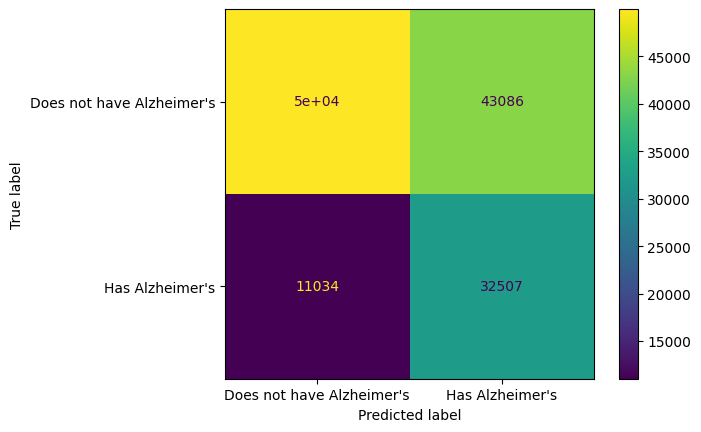

In [12]:
cm = confusion_matrix(y_test, a_model.predict(X_test))
ConfusionMatrixDisplay(cm, display_labels=["Does not have Alzheimer's", "Has Alzheimer's"]).plot()

In [40]:
features = X.columns
features

Index(['AGE_GROUP', 'NAME', 'SEX', 'RACE', 'Frequent mental distress',
       'Prevalence of sufficient sleep', 'Eating 2 or more fruits daily',
       'Eating 3 or more vegetables daily', 'Lifetime diagnosis of depression',
       'Obesity', 'Fall with injury within last year'],
      dtype='object')

In [42]:
for model_name, model in tuned_models.items():
    data_stimulated[f"Predicted_{model_name}"] = model.predict(data_stimulated[features])

In [55]:
data_stimulated[["Predicted_lr_saga_l2", "Predicted_gb", "Predicted_rf", "Predicted_knn", "Predicted_mlp"]].sum(axis=1).value_counts()

0    444255
5    308791
1    268393
4    136295
2    114653
3     93666
Name: count, dtype: int64

In [43]:
X = data_stimulated.drop(["HAS_ALZHEIMERS", "Oral health:  tooth retention"], axis=1) # , "Oral health:  tooth retention"
y = data_stimulated["HAS_ALZHEIMERS"]

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=.1, 
    random_state=int(rng.random() * 280741231))

In [49]:
tuned_model.fit(X_train, y_train)

TunedThresholdClassifierCV(estimator=RandomForestClassifier(criterion='log_loss',
                                                            n_jobs=-1,
                                                            random_state=2000334825),
                           n_jobs=-1, store_cv_results=True)

In [50]:
accuracy_score(y_test, tuned_model.predict(X_test)), f1_score(y_test, tuned_model.predict(X_test)), precision_score(y_test, tuned_model.predict(X_test)), recall_score(y_test, tuned_model.predict(X_test))

(0.6625770463962052,
 0.5289705491630731,
 0.4771667189026751,
 0.5933924845816998)

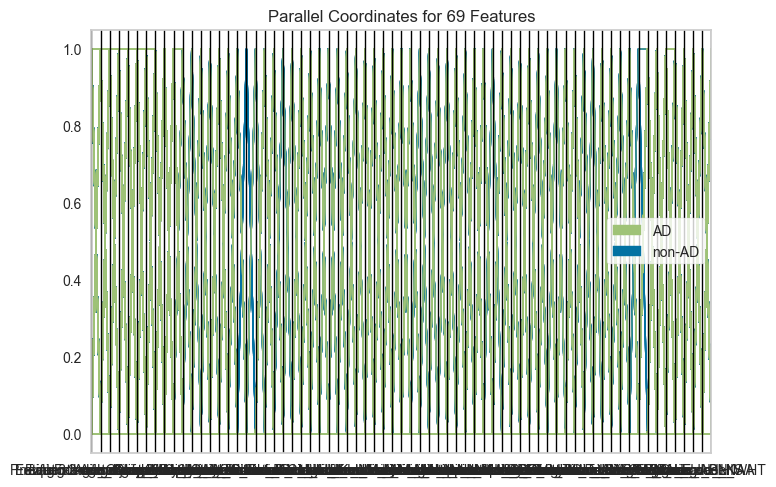

,Frequent mental distress,Prevalence of sufficient sleep,Eating 2 or more fruits daily,Eating 3 or more vegetables daily,Lifetime diagnosis of depression,Obesity,Fall with injury within last year,Age_Group_50-64 years,Age_Group_65 years or older,Age_Group_Overall,...,Location_Wisconsin,Location_Wyoming,Sex_FEMALE,Sex_MALE,Sex_Overall,Race_code_ASN,Race_code_BLK,Race_code_HIS,Race_code_NAA,Race_code_WHT
485012,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
374057,0,1,0,0,1,0,1,0,1,0,...,0,0,0,1,0,0,0,0,0,1
440730,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,1,0,0,0
1121084,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,1,0,1,0,0,0
1195864,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612779,0,1,0,1,0,0,0,0,0,1,...,0,0,0,1,0,1,0,0,0,0
258801,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
720905,1,1,0,0,0,1,1,0,0,1,...,0,0,1,0,0,0,1,0,0,0
746901,0,0,0,0,0,1,1,0,0,1,...,0,0,1,0,0,0,0,0,0,1


In [15]:
from yellowbrick.features import ParallelCoordinates
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

visualizer = ParallelCoordinates(
    classes=["non-AD",  "AD"],
    features=X_train.columns,
    sample=0.01,
    shuffle=True,
    fast=True
)
visualizer.fit_transform_show(X_train, y_train)
